# Urban Expansion and Its Impact on Biodiversity: A Study of BII Changes in Phoenix, Arizona

Author: Karol Paya

Github Repository: https://github.com/kpaya/impacts-of-urban-expansion-analysis

![Phoenix](data/Phoenix.jpg)
Source: [Kayak, 2024](https://www.kayak.com/Phoenix.18004.guide)

# Project Description

**Purpose:**

Maricopa County, home to the Phoenix metropolitan area, experienced the largest increase in developed land in the U.S. since 2001 [(Washington Post, 2021)](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). This rapid urban sprawl poses significant challenges to local biodiversity and the integrity of natural ecosystems. This notebook will examine the changes in Biodiversity Intactness Index (BII) within the Phoenix county subdivision area between 2017 and 2020, providing insights into how urban growth has influenced biodiversity over time.

**Highlights:**

This notebook contains two reusable functions, biodiversity_function and percent_function, which significantly streamline the analysis workflow. By automating data wrangling and key calculations such as the Biodiversity Intactness Index (BII) and percentage change, these functions ensure consistency and efficiency throughout the process.

**About the Data:**

**References:**

Microsoft Planetary Computer. Biodiversity Intactness. [Dataset]. Microsoft. Retrieved December 5, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

Census Bureau, TIGER/Line Shapefiles. Census.Gov. 2024 County Subdivison Shapefile. [Dataset]. United States Census Bureau. Retrieved December 5, 2024, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

Microsoft Planetary Computer. Biodiversity Intactness. [Dataset]. Microsoft. Retrieved December 5, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

Census Bureau, TIGER/Line Shapefiles. Census.Gov. 2024 County Subdivison Shapefile. [Dataset]. United States Census Bureau. Retrieved December 5, 2024, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

# Data access

The datasets hosted by the Planetary Computer are available from Azure Blob Storage. We'll use pystac-client to search the Planetary Computer's STAC API for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a modifier so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See Reading from the STAC API and Using tokens for data access for more.

# Import libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 
from IPython.display import Image  # To nicely display images
from shapely import box
from pyproj import CRS
import xarray as xr
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

catalog.get_collections()


# Load state shapefile
state= gpd.read_file(os.path.join('data','tl_2020_04_cousub.shp')
                                             )

# Data Exploration

In [4]:
# For eastern Arizona (EPSG:26913)
crs_utm_13n = CRS.from_epsg(26913)

# To get the unit of measurement (meters)

print(f"Units for UTM Zone 13N: {crs_utm_13n.axis_info[0].unit_name}")

Units for UTM Zone 13N: metre


Create a map showing the Phoenix subdivision within its broader geographic context. You may use any vector or raster datasets to create your map. Be sure to include citations or descriptions for these datasets at the top of your notebook too. You may also want to check out the contextily package to add a base map.

# Select a region and find STAC Items

Let's look at an area centered on the Maricopa County, part of the Phoenix metropolitan area

In [5]:
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Temporal range of interest
time_range = "2017-01-01/2020-01-01"

# NCEAS bounding box (as a GeoJSON)
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-112.826843, 32.974108],  # Bottom-left corner
            [-112.826843, 33.863574],  # Top-left corner
            [-111.184387, 33.863574],  # Top-right corner
            [-111.184387, 32.974108],  # Bottom-right corner
            [-112.826843, 32.974108]   # Back to bottom-left corner to close the polygon
        ]
    ],
}

# Catalog search
search = catalog.search(
    collections = ["io-biodiversity"],
    intersects = bbox,
    datetime = time_range)
search

In [6]:
# Retrieve search items
items = search.item_collection()
len(items)

items

In [7]:
# Get first item in the catalog search
item = items[1]
type(item)

pystac.item.Item

In [8]:
# Print item ID and properties
print('ID:' , item.id)
item.properties

ID: bii_2019_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2019-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2019-01-01T00:00:00Z'}

The CRS EPSG:4326 (WGS 84) is a geographic coordinate system that uses degrees as its units, not meters.

In [9]:
for key in item.assets.keys():
    print(key, '--', item.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [10]:
# Plot rendered preview
Image(url=item.assets['rendered_preview'].href, width=500)

In [11]:
def biodiversity_function(year, city):
    # Define year_dict
    year_dict = {
        2020: 0,
        2019: 1,
        2018: 2,
        2017: 3
    }
    items = search.item_collection()
    # Get the item for assigned year
    item = items[year_dict[year]]
    
    # Open biodiversity data from the catalog
    biodiversity = rioxr.open_rasterio(item.assets['data'].href)

    # Remove length 1 dimension (band) and drop unnecessary variables
    biodiversity = biodiversity.squeeze().drop_vars('band')

    # Create GeoDataFrame from raster bounding box
    biodiversity_bbox = gpd.GeoDataFrame(geometry=[box(*biodiversity.rio.bounds())], crs=biodiversity.rio.crs)
    
    # Filter the city area based on city name
    city_area = state[state['NAME'] == city]

    # Reproject the biodiversity bounding box and city area to match each other's CRS
    biodiversity_bbox = biodiversity_bbox.to_crs(city_area.crs)
    city_area_match = city_area.to_crs(biodiversity.rio.crs)
    
    # Ensure CRS match
    assert city_area_match.crs == biodiversity.rio.crs

    # Print original no-data value of the raster
    print('Original no-data value: ', biodiversity.rio.nodata)

    # Update the raster's no-data value to 0
    biodiversity = biodiversity.rio.write_nodata(0)
    print('Updated no-data value: ', biodiversity.rio.nodata)

    # Clip the raster by the city area (Phoenix in this case)
    biodiversity_clip = (biodiversity.rio.clip_box(*city_area_match.total_bounds)
                         .rio.clip(city_area_match.geometry))

    # Return the the clipped biodiversity_clip and the city polygon
    return biodiversity_clip, city_area

In [27]:
def percent_function(biodiversity, year):
    biodiversity_clip=biodiversity[0]
    phoenix_area=biodiversity[1]

    biodiversity_clip_26913 = biodiversity_clip.rio.reproject("EPSG:26913") 
    
    print(f"Resolution: {biodiversity_clip_26913.rio.resolution()}")

    #return_counts: If True, also return the number of times each unique item appears in ar
    pixel_values, pixel_counts = np.unique(biodiversity_clip_26913.values, return_counts=True)

    pixel_df = pd.DataFrame({
        'pixel_value': pixel_values,
        'pixel_count': pixel_counts
    })

    # Compute the total count of pixels in Phoenix subdivision
    total_pixels=sum(pixel_df['pixel_count'])

    # Apply the condition to filter pixel values >= 0.75
    threshold = 0.75
    pixel_df_075 = pixel_df[pixel_df['pixel_value'] >= threshold]

    # Calculate Pixel Area
    pixel_area = abs(biodiversity_clip_26913.rio.resolution()[0]) * abs(biodiversity_clip_26913.rio.resolution()[1])
    print(f"Area of one pixel: {pixel_area/1000000:.3f} square Km") # 1 km² = 1,000,000 m²

    # Total area covered by the raster
    total_pixels_075=sum(pixel_df_075['pixel_count'])
    print(f"{year} Total pixels above threshold in {year}: {total_pixels_075}")
    total_area_075 = total_pixels_075 * pixel_area
    print(f"{year} Total area with a BII of at least 0.75: {total_area_075:.0f} square km")

    # Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75
    percent= ((total_pixels_075 * pixel_area)/(total_pixels* pixel_area))*100
    print(f"{year} Total percent area with a BII of at least 0.75 : {percent:.1f} %")
    
    # Apply condition: pixel value >= 0.75
    filtered_raster = xr.DataArray(np.where(biodiversity_clip >= threshold, 1, 0))   

    # Return total percent and the df with BII >=0.75
    return percent,filtered_raster

In [43]:
year=2020
biodiversity_2020 = biodiversity_function(year, 'Phoenix')
percent_2020 = percent_function(biodiversity_2020, 'Phoenix')

Original no-data value:  None
Updated no-data value:  0.0
Resolution: (88.31128751748638, -88.31128751748638)
Area of one pixel: 0.008 square Km
Phoenix Total pixels above threshold in Phoenix: 23621
Phoenix Total area with a BII of at least 0.75: 184217427 square km
Phoenix Total percent area with a BII of at least 0.75 : 3.3 %


In [42]:
year=2017
biodiversity_2017 = biodiversity_function(year, 'Phoenix')
percent_2017 = percent_function(biodiversity_2017, 'Phoenix')

Original no-data value:  None
Updated no-data value:  0.0
Resolution: (88.31128751748638, -88.31128751748638)
Area of one pixel: 0.008 square Km
Phoenix Total pixels above threshold in Phoenix: 25907
Phoenix Total area with a BII of at least 0.75: 202045675 square km
Phoenix Total percent area with a BII of at least 0.75 : 3.6 %


Original no-data value:  None
Updated no-data value:  0.0
Original no-data value:  None
Updated no-data value:  0.0


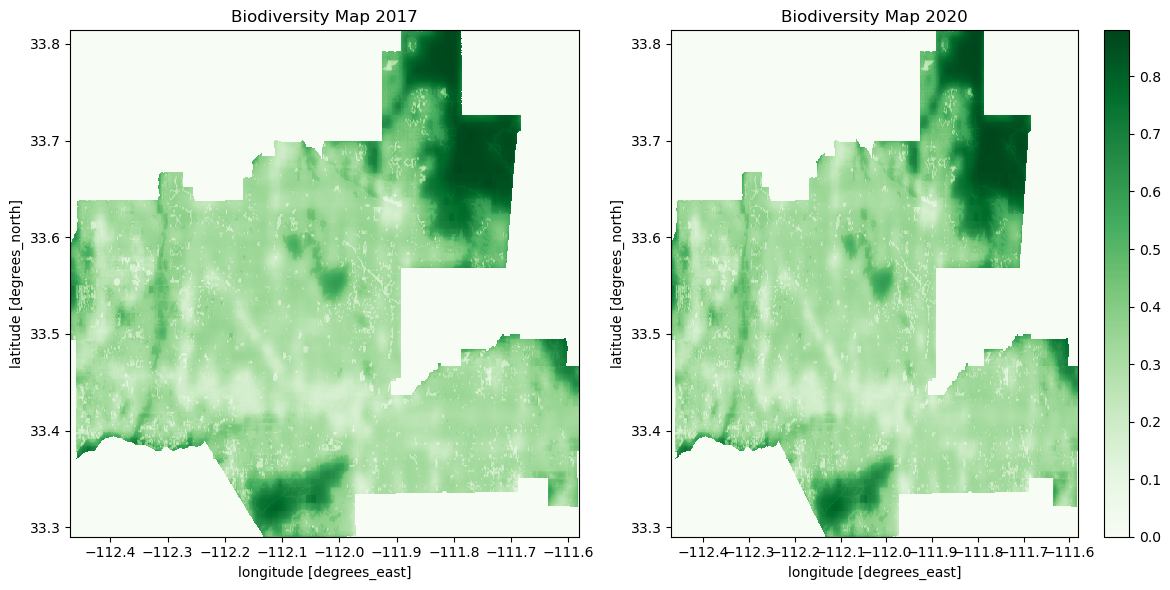

In [67]:
# Get biodiversity data for 2020 and 2017
#ax.axis('off')
biodiversity_2020 = biodiversity_function(2020, 'Phoenix')
biodiversity_2017 = biodiversity_function(2017, 'Phoenix')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the 2017 biodiversity map
biodiversity_2020[0].plot(ax=axes[0], cmap='Greens',add_colorbar=False)
axes[0].set_title("Biodiversity Map 2017")

# Plot the 2020 biodiversity map
biodiversity_2020[0].plot(ax=axes[1], cmap='Greens')
axes[1].set_title("Biodiversity Map 2020")

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
diff=percent_2017[1]-percent_2020[1]
diff_filtered = diff.where(diff == 1)

diff_filtered_reprojected = diff_filtered.rio.write_crs(biodiversity_2017[1].crs)

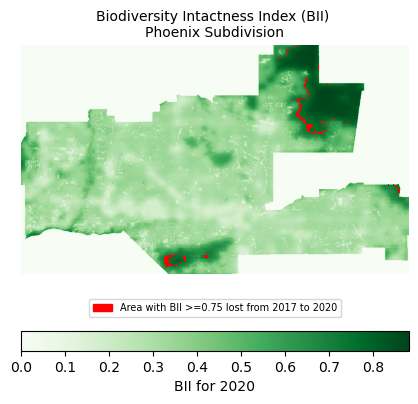

In [78]:
# Create map
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

# Plot the biodiversity map
background_plot=ax.imshow(biodiversity_2020[0], cmap='Greens')
background_plot

# Create a custom colormap: Only show 1 as red, others will be transparent (NaN)
cmap = mcolors.ListedColormap([ 'red'])  # Red for 1, transparent for NaN
bounds = [0, 1]  # Values between 0 and 1 are masked out (transparent), 1 will be red
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# plot the difference filtered dataset
diff_filtered_reprojected.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

# Create a custom legend for the difference map (change in BII)
red_patch = mpatches.Patch(color='red', label="Area with BII >=0.75 lost from 2017 to 2020")

# Add the custom legend for the BII lost
ax.legend(handles=[red_patch], loc='center', fontsize=7, bbox_to_anchor=(0.5, -0.15))

# Add a colorbar
plt.colorbar(background_plot, ax=ax, orientation='horizontal', label="BII for 2020")

# Add a title
ax.set_title("Biodiversity Intactness Index (BII) \nPhoenix Subdivision", fontsize=10)

# Reverse the y-axis
ax.invert_yaxis()

# Show plot
plt.show()